In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
import seaborn as sns
import sys
import torch

import warnings
#warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore')

In [2]:
from ZORO import benchmarkfunctions
from ZORO import optimizers

## Generate Data

In [3]:
# Dimensionality of data -- we tweak this to run our experiments
dim = 100             #10, 100, 1000, 10000
informative = 100     # 1,  10,  100,  1000

In [4]:
from sklearn.datasets import make_classification, make_blobs
# Cluster of points normally distributed (std=1) about vertices
# of an n_informative-dim hypercube with sides of length 2*class_sep

# Features are ordered: n_informative, n_redundant, n_repeated, 
# then random noise
def generate_samples(n_features, n_informative, n_samples=100):
    """
    return make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=2,
        random_state=42
        
    )
    """
    return make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_informative,
        n_redundant=0, 
        n_repeated=0, 
        n_classes=2, 
        n_clusters_per_class=1, 
        flip_y=0.01, 
        class_sep=2, 
        random_state=42,
        shuffle=False
    )

X, y = generate_samples(dim, informative)

### Plot of Projection onto 2 Dimensions

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

<AxesSubplot:>

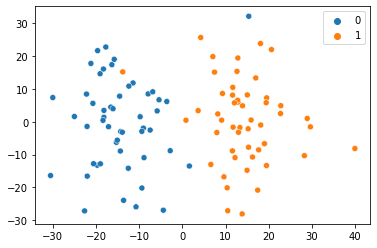

In [7]:
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=y)

## Linear Separator

In [8]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=42, max_iter=1000)
clf.fit(X, y)
print("Number of iterations", clf.n_iter_)
print("Accuracy:", clf.score(X, y))

Number of iterations 43
Accuracy: 1.0


In [9]:
y[y == 0] = -1
y

array([-1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [10]:
w_norm = np.linalg.norm(clf.coef_)

## ZORO Attack

In [11]:
# Adversarial Attack Loss
class AttackLoss(object):
    '''An implementation of the sparse quadric function.'''
    def __init__(self, predictor, lamb, norm, x_original, y_true, y_attack):
        self.predictor = predictor
        self.lamb = lamb
        self.norm = norm
        
        self.x_original = x_original
        self.y_true = y_true
        self.y_attack = y_attack
        
    def __call__(self, x_attack):
        ## (f(x + delta) - y_attack + y_true)^2 + lambda ||delta||_0
        prediction = self.predictor.decision_function(x_attack)
                
        return (prediction - self.y_attack)**2 \
              + self.lamb * np.linalg.norm((x_attack - self.x_original), self.norm, axis=1)

In [12]:
class AdaZOROExperiment:
    
    def __init__(self, step_size=None, delta=None, max_cosamp_iter=None, 
                 cosamp_tol=None, prop_sparsity=None, lamb=None, norm=None,
                 function_budget=None, num_samples_constant=None, phi_cosamp=None,
                 phi_lstsq=None, compessible_constant=None):
        self.step_size = step_size
        self.delta = delta
        self.max_cosamp_iter = max_cosamp_iter
        self.cosamp_tol = cosamp_tol
        self.prop_sparsity = prop_sparsity
        self.lamb = lamb
        self.norm = norm
        self.function_budget = function_budget
        self.num_samples_constant=num_samples_constant
        self.phi_cosamp=phi_cosamp
        self.phi_lstsq=phi_lstsq
        self.compessible_constant=compessible_constant
        
    def score(self, X, y):
        return self.loss
    
    def get_params(self, deep=True):
        return {
            # Parameters for ZORO. 
            "step_size": self.step_size,
            "delta": self.delta,
            "max_cosamp_iter": self.max_cosamp_iter,
            "cosamp_tol": self.cosamp_tol,
            "prop_sparsity": self.prop_sparsity,
            "lamb" : self.lamb,
            "norm" : self.norm,
            "function_budget" : self.function_budget,
            "num_samples_constant": self.num_samples_constant,
            "phi_cosamp": self.phi_cosamp,
            "phi_lstsq": self.phi_lstsq,
            "compessible_constant": self.compessible_constant,
        }
    
    def set_params(self, **kwargs):
        for parameter, value in kwargs.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, X, y):
        self.report = []
        
        params = {
            "step_size": self.step_size,
            "delta": self.delta,
            "max_cosamp_iter": self.max_cosamp_iter,
            "cosamp_tol": self.cosamp_tol,
            "prop_sparsity": self.prop_sparsity,
            "lamb" : self.lamb,
            "norm" : self.norm,
            "function_budget" : self.function_budget,
            "num_samples_constant": self.num_samples_constant,
            "phi_cosamp": self.phi_cosamp,
            "phi_lstsq": self.phi_lstsq,
            "compessible_constant": self.compessible_constant,
        }
        
        print(params)

        params["sparsity"] = int(params["prop_sparsity"] * X.shape[1])
        params["num_samples"] = int(np.ceil(np.log(X.shape[1])*params["sparsity"]))

        # Compute attack loss for each data point individually
        for i in range(len(X)):
            x0           = X[i, :]
            xx0          = x0.copy()

            label        = y[i]
            label_attack = -y[i]

            obj_func = AttackLoss(
                predictor=clf, 
                lamb=self.lamb, 
                norm=self.norm, 
                x_original=xx0,
                y_true=label,
                y_attack=label_attack
            )

            # initialize optimizer object
            self.report.append([{"evals": 0, "x": x0, "y": label, "sparsity": params["sparsity"], "loss": obj_func(np.expand_dims(x0, 0))[0]}])
            opt = optimizers.AdaZORO(x0, obj_func, params, function_budget=self.function_budget, function_target=0.001)

            # the optimization routine
            termination = False
            while termination is False:
                # optimization step
                # solution_ZORO = False until a termination criterion is met, in which 
                # case solution_ZORO = the solution found.
                # termination = False until a termination criterion is met.
                # If ZORO terminates because function evaluation budget is met, 
                # termination = B
                # If ZORO terminated because the target accuracy is met,
                # termination= T.

                evals_ZORO, sparsity, solution_ZORO, termination = opt.step()

                # save some useful values
                self.report[-1].append({"evals" : evals_ZORO, "x": solution_ZORO, "sparsity": sparsity, "loss": np.mean(opt.fd)})
                # print some useful values
                opt.report( f'Estimated f(x_{i}): %f  function evals: %d\n' %
                    (np.mean(opt.fd), evals_ZORO) )
        self.loss = sum([self.report[i][-1]["loss"] for i in range(len(self.report))]) / len(self.report)

### Hyperparameter Search

In [16]:
# Parameters to search for ZORO attack
lamb = 0.1
adaparams = {
    "step_size": [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    "delta": [1e-3, 1e-4, 1e-5], 
    "max_cosamp_iter": [5, 10, 15, 20, 25],
    "cosamp_tol": [0.5], 
    "prop_sparsity": [0.05, 0.10, 0.15, 0.20, 0.25], 
    "lamb" : [lamb], 
    "norm" : [2],
    "function_budget": [5e4],# for hyperparameter tuning, we give this as a budget
    "num_samples_constant": [dim], 
    "phi_cosamp": [0.2, 0.4, 0.6, 0.8],
    "phi_lstsq": [0.05, 0.1, 0.15, 0.20, 0.25],
    "compessible_constant": [1, 1.1, 1.25, 1.5, 2]
}

In [17]:
clf_search = sklearn.model_selection.RandomizedSearchCV(
    estimator = AdaZOROExperiment(),
    param_distributions = adaparams,
    n_iter = 100, # Run 100 random trials
    n_jobs = 10, # Run 20 jobs at once
    refit = False,
    cv = ShuffleSplit(n_splits=1, train_size=16, random_state=42), # We attack the same 16 examples for every trial
    error_score=np.nan,
    random_state = 42
)

In [18]:
search_results = clf_search.fit(X, y)

{'step_size': 10.0, 'delta': 0.001, 'max_cosamp_iter': 20, 'cosamp_tol': 0.5, 'prop_sparsity': 0.05, 'lamb': 0.1, 'norm': 2, 'function_budget': 50000.0, 'num_samples_constant': 100, 'phi_cosamp': 0.8, 'phi_lstsq': 0.1, 'compessible_constant': 1.1}
Current Sparsity:  5
Estimated f(x_0): 3.996832  function evals: 2305
Current Sparsity:  5
Estimated f(x_0): 4.876157  function evals: 2416
{'step_size': 0.1, 'delta': 0.0001, 'max_cosamp_iter': 10, 'cosamp_tol': 0.5, 'prop_sparsity': 0.05, 'lamb': 0.1, 'norm': 2, 'function_budget': 50000.0, 'num_samples_constant': 100, 'phi_cosamp': 0.6, 'phi_lstsq': 0.15, 'compessible_constant': 1.25}
Current Sparsity:  5
Estimated f(x_0): 3.996832  function evals: 2305
Current Sparsity:  5
Estimated f(x_0): 3.702178  function evals: 2527
Current Sparsity:  5
Estimated f(x_0): 3.987545  function evals: 2431
Current Sparsity:  5
Estimated f(x_0): 3.167993  function evals: 2638
Current Sparsity:  5
Estimated f(x_0): 3.964864  function evals: 2557
Current Spar

Current Sparsity:  20
Estimated f(x_0): 3.919800  function evals: 9768
Current Sparsity:  5
Estimated f(x_0): 3.305064  function evals: 8353
Current Sparsity:  5
Estimated f(x_0): 1.433089  function evals: 7744
Current Sparsity:  15
Estimated f(x_0): 1.551366  function evals: 12016
Current Sparsity:  5
Estimated f(x_0): 3.946802  function evals: 8335
Current Sparsity:  5
Estimated f(x_0): 3.567737  function evals: 7933
Current Sparsity:  5
Estimated f(x_0): 1.432019  function evals: 7855
Current Sparsity:  5
Estimated f(x_0): 3.293061  function evals: 8479
Current Sparsity:  20
Estimated f(x_0): 3.900424  function evals: 9879
Current Sparsity:  15
Estimated f(x_0): 1.543557  function evals: 12127
Current Sparsity:  5
Estimated f(x_0): 3.945190  function evals: 8536
Current Sparsity:  5
Estimated f(x_0): 3.554061  function evals: 8134
Current Sparsity:  5
Estimated f(x_0): 1.431101  function evals: 7966
Current Sparsity:  5
Estimated f(x_0): 3.281136  function evals: 8605
Current Sparsi

Current Sparsity:  25
Estimated f(x_0): 3.986998  function evals: 12323
Current Sparsity:  5
Estimated f(x_0): 3.916357  function evals: 12154
Current Sparsity:  5
Estimated f(x_0): 3.310232  function evals: 11953
Current Sparsity:  20
Estimated f(x_0): 3.533227  function evals: 12543
Current Sparsity:  5
Estimated f(x_0): 3.026970  function evals: 11503
Current Sparsity:  5
Estimated f(x_0): 1.425575  function evals: 10519
Current Sparsity:  20
Estimated f(x_0): 6.734019  function evals: 10627
Current Sparsity:  15
Estimated f(x_0): 1.451539  function evals: 14791
Current Sparsity:  25
Estimated f(x_0): 1.709944  function evals: 12319
Current Sparsity:  25
Estimated f(x_0): 3.984841  function evals: 12424
Current Sparsity:  20
Estimated f(x_0): 3.519671  function evals: 12654
Current Sparsity:  5
Estimated f(x_0): 3.016748  function evals: 11629
Current Sparsity:  5
Estimated f(x_0): 1.425544  function evals: 10630
Current Sparsity:  5
Estimated f(x_0): 3.914765  function evals: 12355

Current Sparsity:  5
Estimated f(x_0): 1.425315  function evals: 13294
Current Sparsity:  20
Estimated f(x_0): 6.138019  function evals: 13354
Current Sparsity:  20
Estimated f(x_0): 3.208847  function evals: 15429
Current Sparsity:  5
Estimated f(x_0): 3.073131  function evals: 16174
Current Sparsity:  15
Estimated f(x_0): 1.431135  function evals: 17677
Current Sparsity:  25
Estimated f(x_0): 3.936342  function evals: 15151
Current Sparsity:  5
Estimated f(x_0): 2.781362  function evals: 14779
Current Sparsity:  5
Estimated f(x_0): 1.425313  function evals: 13405
Current Sparsity:  25
Estimated f(x_0): 1.433171  function evals: 16540
Current Sparsity:  25
Estimated f(x_0): 3.994035  function evals: 15334
Current Sparsity:  5
Estimated f(x_0): 3.884711  function evals: 16174
Current Sparsity:  20
Estimated f(x_0): 6.118014  function evals: 13455
Current Sparsity:  20
Estimated f(x_0): 3.197445  function evals: 15540
Current Sparsity:  25
Estimated f(x_0): 3.934688  function evals: 152

Current Sparsity:  5
Estimated f(x_0): 2.580807  function evals: 17929
Current Sparsity:  20
Estimated f(x_0): 5.643578  function evals: 16081
Current Sparsity:  25
Estimated f(x_0): 1.425613  function evals: 20560
Current Sparsity:  20
Estimated f(x_0): 2.935084  function evals: 18315
Current Sparsity:  25
Estimated f(x_0): 3.892666  function evals: 17878
Current Sparsity:  5
Estimated f(x_0): 1.425293  function evals: 16180
Current Sparsity:  5
Estimated f(x_0): 2.865863  function evals: 20395
Current Sparsity:  15
Estimated f(x_0): 1.427020  function evals: 20563
Current Sparsity:  20
Estimated f(x_0): 5.626976  function evals: 16182
Current Sparsity:  5
Estimated f(x_0): 2.573433  function evals: 18055
Current Sparsity:  25
Estimated f(x_0): 3.990899  function evals: 19153
Current Sparsity:  5
Estimated f(x_0): 3.855022  function evals: 19993
Current Sparsity:  20
Estimated f(x_0): 2.925443  function evals: 18426
Current Sparsity:  25
Estimated f(x_0): 1.425562  function evals: 207

Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 18955
Current Sparsity:  25
Estimated f(x_0): 3.850212  function evals: 20605
Current Sparsity:  25
Estimated f(x_0): 1.425255  function evals: 24781
Current Sparsity:  5
Estimated f(x_0): 2.403635  function evals: 21205
Current Sparsity:  25
Estimated f(x_0): 3.987748  function evals: 22972
Current Sparsity:  5
Estimated f(x_0): 3.825693  function evals: 23812
Current Sparsity:  20
Estimated f(x_0): 5.219304  function evals: 18909
Current Sparsity:  15
Estimated f(x_0): 1.426023  function evals: 23449
Current Sparsity:  20
Estimated f(x_0): 2.695326  function evals: 21312
Current Sparsity:  25
Estimated f(x_0): 3.848657  function evals: 20706
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 19066
Current Sparsity:  5
Estimated f(x_0): 2.684668  function evals: 24616
Current Sparsity:  5
Estimated f(x_0): 2.397392  function evals: 21331
Current Sparsity:  25
Estimated f(x_0): 1.425252  function evals: 2498

Current Sparsity:  20
Estimated f(x_0): 4.869148  function evals: 21737
Current Sparsity:  25
Estimated f(x_0): 3.984443  function evals: 26992
Current Sparsity:  5
Estimated f(x_0): 3.795202  function evals: 27832
Current Sparsity:  5
Estimated f(x_0): 2.526264  function evals: 28837
Current Sparsity:  5
Estimated f(x_0): 2.248344  function evals: 24607
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 21952
Current Sparsity:  20
Estimated f(x_0): 2.493689  function evals: 24309
Current Sparsity:  25
Estimated f(x_0): 3.805562  function evals: 23534
Current Sparsity:  15
Estimated f(x_0): 1.425672  function evals: 26446
Current Sparsity:  25
Estimated f(x_0): 1.425231  function evals: 29203
Current Sparsity:  20
Estimated f(x_0): 4.857839  function evals: 21838
Current Sparsity:  20
Estimated f(x_0): 2.486870  function evals: 24420
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 22063
Current Sparsity:  25
Estimated f(x_0): 3.984278  function evals: 271

Current Sparsity:  5
Estimated f(x_0): 2.381642  function evals: 33259
Current Sparsity:  15
Estimated f(x_0): 1.425503  function evals: 29443
Current Sparsity:  25
Estimated f(x_0): 1.425228  function evals: 33424
Current Sparsity:  5
Estimated f(x_0): 2.122149  function evals: 27883
Current Sparsity:  20
Estimated f(x_0): 4.570468  function evals: 24666
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 25060
Current Sparsity:  25
Estimated f(x_0): 3.761786  function evals: 26463
Current Sparsity:  20
Estimated f(x_0): 2.318346  function evals: 27417
Current Sparsity:  25
Estimated f(x_0): 3.980987  function evals: 31213
Current Sparsity:  5
Estimated f(x_0): 3.763604  function evals: 32053
Current Sparsity:  15
Estimated f(x_0): 1.425498  function evals: 29554
Current Sparsity:  5
Estimated f(x_0): 2.117703  function evals: 28009
Current Sparsity:  5
Estimated f(x_0): 2.375539  function evals: 33460
Current Sparsity:  20
Estimated f(x_0): 4.561179  function evals: 2476

Current Sparsity:  25
Estimated f(x_0): 3.720307  function evals: 29291
Current Sparsity:  5
Estimated f(x_0): 2.011538  function evals: 31285
Current Sparsity:  5
Estimated f(x_0): 2.256016  function evals: 37681
Current Sparsity:  20
Estimated f(x_0): 2.176583  function evals: 30414
Current Sparsity:  25
Estimated f(x_0): 1.425228  function evals: 38047
Current Sparsity:  20
Estimated f(x_0): 4.324977  function evals: 27595
Current Sparsity:  25
Estimated f(x_0): 3.977707  function evals: 35233
Current Sparsity:  5
Estimated f(x_0): 3.733902  function evals: 36073
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 28168
Current Sparsity:  15
Estimated f(x_0): 1.425399  function evals: 32551
Current Sparsity:  25
Estimated f(x_0): 3.718840  function evals: 29392
Current Sparsity:  5
Estimated f(x_0): 2.007797  function evals: 31411
Current Sparsity:  20
Estimated f(x_0): 2.171789  function evals: 30525
Current Sparsity:  5
Estimated f(x_0): 2.250715  function evals: 3788

Current Sparsity:  15
Estimated f(x_0): 1.425342  function evals: 35215
Current Sparsity:  25
Estimated f(x_0): 3.682462  function evals: 31917
Current Sparsity:  20
Estimated f(x_0): 2.065471  function evals: 33189
Current Sparsity:  25
Estimated f(x_0): 3.974764  function evals: 38851
Current Sparsity:  5
Estimated f(x_0): 3.707493  function evals: 39691
Current Sparsity:  5
Estimated f(x_0): 2.156189  function evals: 41701
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 30943
Current Sparsity:  20
Estimated f(x_0): 4.141991  function evals: 30221
Current Sparsity:  5
Estimated f(x_0): 1.924837  function evals: 34435
Current Sparsity:  25
Estimated f(x_0): 1.425228  function evals: 42268
Current Sparsity:  15
Estimated f(x_0): 1.425340  function evals: 35326
Current Sparsity:  25
Estimated f(x_0): 3.681019  function evals: 32018
Current Sparsity:  20
Estimated f(x_0): 2.061386  function evals: 33300
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 310

Current Sparsity:  25
Estimated f(x_0): 1.425228  function evals: 47494
Current Sparsity:  20
Estimated f(x_0): 3.950858  function evals: 33554
Current Sparsity:  5
Estimated f(x_0): 1.834918  function evals: 38341
Current Sparsity:  25
Estimated f(x_0): 3.633920  function evals: 35351
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 34606
Current Sparsity:  15
Estimated f(x_0): 1.425292  function evals: 38878
Current Sparsity:  20
Estimated f(x_0): 1.943559  function evals: 36852
Current Sparsity:  25
Estimated f(x_0): 3.970851  function evals: 43675
Current Sparsity:  5
Estimated f(x_0): 2.044127  function evals: 46927
Current Sparsity:  5
Estimated f(x_0): 3.672751  function evals: 44515
Current Sparsity:  20
Estimated f(x_0): 3.945689  function evals: 33655
Current Sparsity:  25
Estimated f(x_0): 1.425228  function evals: 47695
Current Sparsity:  5
Estimated f(x_0): 1.832304  function evals: 38467
Current Sparsity:  25
Estimated f(x_0): 3.632508  function evals: 354

Current Sparsity:  25
Estimated f(x_0): 3.594734  function evals: 38179
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 37603
Current Sparsity:  20
Estimated f(x_0): 3.813801  function evals: 36483
Current Sparsity:  5
Estimated f(x_1): 5.125269  function evals: 2506
Current Sparsity:  25
Estimated f(x_0): 3.967598  function evals: 47695
Current Sparsity:  5
Estimated f(x_0): 3.644204  function evals: 48535
Current Sparsity:  15
Estimated f(x_0): 1.425266  function evals: 41875
Current Sparsity:  5
Estimated f(x_0): 1.769894  function evals: 41743
Current Sparsity:  20
Estimated f(x_0): 1.861292  function evals: 39849
Current Sparsity:  25
Estimated f(x_0): 3.593347  function evals: 38280
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 37714
Current Sparsity:  20
Estimated f(x_0): 3.809519  function evals: 36584
Current Sparsity:  15
Estimated f(x_0): 1.425266  function evals: 41986
Current Sparsity:  5
Estimated f(x_1): 5.099361  function evals: 2707


Current Sparsity:  20
Estimated f(x_0): 1.785107  function evals: 43179
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 41155
Current Sparsity:  5
Estimated f(x_0): 1.707861  function evals: 45649
Current Sparsity:  25
Estimated f(x_0): 3.548088  function evals: 41613
Current Sparsity:  15
Estimated f(x_0): 1.425248  function evals: 45427
Current Sparsity:  20
Estimated f(x_0): 3.682535  function evals: 39917
Current Sparsity:  5
Estimated f(x_1): 4.602463  function evals: 7531
Current Sparsity:  5
Estimated f(x_1): 5.129325  function evals: 4717
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 41266
Current Sparsity:  20
Estimated f(x_0): 1.782810  function evals: 43290
Current Sparsity:  5
Estimated f(x_0): 1.706058  function evals: 45775
Current Sparsity:  15
Estimated f(x_0): 1.425247  function evals: 45538
Current Sparsity:  25
Estimated f(x_0): 3.546731  function evals: 41714
Current Sparsity:  20
Estimated f(x_0): 3.679087  function evals: 40018


Current Sparsity:  20
Estimated f(x_0): 1.726059  function evals: 46287
Current Sparsity:  5
Estimated f(x_1): 4.196841  function evals: 12154
Current Sparsity:  15
Estimated f(x_0): 1.425237  function evals: 48646
Current Sparsity:  20
Estimated f(x_0): 3.590818  function evals: 42846
Current Sparsity:  5
Estimated f(x_1): 5.080577  function evals: 9139
Current Sparsity:  5
Estimated f(x_0): 1.659979  function evals: 49303
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 44485
Current Sparsity:  25
Estimated f(x_0): 3.507765  function evals: 44643
Current Sparsity:  20
Estimated f(x_0): 1.724139  function evals: 46398
Current Sparsity:  15
Estimated f(x_0): 1.425237  function evals: 48757
Current Sparsity:  5
Estimated f(x_1): 4.180526  function evals: 12355
Current Sparsity:  20
Estimated f(x_0): 3.587941  function evals: 42947
Current Sparsity:  5
Estimated f(x_0): 1.658481  function evals: 49429
Current Sparsity:  25
Estimated f(x_1): 5.156482  function evals: 11515

Current Sparsity:  25
Estimated f(x_1): 1.654719  function evals: 16339
Current Sparsity:  20
Estimated f(x_0): 1.671917  function evals: 49728
Current Sparsity:  5
Estimated f(x_1): 3.832736  function evals: 16978
Current Sparsity:  20
Estimated f(x_0): 3.506946  function evals: 46078
Current Sparsity:  5
Estimated f(x_1): 4.738915  function evals: 4573
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 47926
Current Sparsity:  25
Estimated f(x_0): 3.466904  function evals: 47774
Current Sparsity:  5
Estimated f(x_1): 5.028203  function evals: 13963
Current Sparsity:  25
Estimated f(x_1): 5.156482  function evals: 11515
Current Sparsity:  20
Estimated f(x_0): 1.670343  function evals: 49839
Current Sparsity:  25
Estimated f(x_1): 1.652891  function evals: 16540
Current Sparsity:  20
Estimated f(x_0): 3.504578  function evals: 46179
Current Sparsity:  25
Estimated f(x_0): 3.465600  function evals: 47875
Current Sparsity:  5
Estimated f(x_0): 1.425291  function evals: 4803

Current Sparsity:  5
Estimated f(x_1): 4.280213  function evals: 2749
Current Sparsity:  20
Estimated f(x_0): 3.441685  function evals: 49108
Current Sparsity:  25
Estimated f(x_1): 1.640727  function evals: 21163
Current Sparsity:  5
Estimated f(x_1): 3.532571  function evals: 21601
Current Sparsity:  15
Estimated f(x_1): 2.591496  function evals: 9130
Current Sparsity:  5
Estimated f(x_1): 4.212291  function evals: 8227
Current Sparsity:  5
Estimated f(x_1): 4.067456  function evals: 2860
Current Sparsity:  20
Estimated f(x_0): 3.439702  function evals: 49209
Current Sparsity:  25
Estimated f(x_1): 5.151586  function evals: 15937
Current Sparsity:  5
Estimated f(x_1): 4.980896  function evals: 18385
Current Sparsity:  25
Estimated f(x_1): 1.640653  function evals: 21364
Current Sparsity:  5
Estimated f(x_1): 3.520496  function evals: 21802
Current Sparsity:  15
Estimated f(x_1): 2.530810  function evals: 9241
Current Sparsity:  5
Estimated f(x_1): 4.195858  function evals: 8353
Curre

Current Sparsity:  20
Estimated f(x_1): 4.912798  function evals: 10323
Current Sparsity:  15
Estimated f(x_1): 1.770950  function evals: 12571
Current Sparsity:  5
Estimated f(x_1): 3.252724  function evals: 26626
Current Sparsity:  25
Estimated f(x_1): 1.640129  function evals: 26389
Current Sparsity:  25
Estimated f(x_1): 5.146301  function evals: 20560
Current Sparsity:  5
Estimated f(x_1): 4.932145  function evals: 23008
Current Sparsity:  5
Estimated f(x_1): 1.985209  function evals: 6412
Current Sparsity:  5
Estimated f(x_1): 3.762550  function evals: 12007
Current Sparsity:  20
Estimated f(x_1): 4.891342  function evals: 10434
Current Sparsity:  15
Estimated f(x_1): 1.763110  function evals: 12682
Current Sparsity:  5
Estimated f(x_1): 3.242435  function evals: 26827
Current Sparsity:  25
Estimated f(x_1): 1.640125  function evals: 26590
Current Sparsity:  5
Estimated f(x_1): 1.953681  function evals: 6523
Current Sparsity:  5
Estimated f(x_1): 3.749001  function evals: 12133
C

Current Sparsity:  15
Estimated f(x_1): 1.663233  function evals: 15901
Current Sparsity:  20
Estimated f(x_1): 4.320048  function evals: 13764
Current Sparsity:  5
Estimated f(x_1): 3.014260  function evals: 31651
Current Sparsity:  20
Estimated f(x_1): 5.123628  function evals: 9617
Current Sparsity:  5
Estimated f(x_1): 3.402838  function evals: 15661
Current Sparsity:  5
Estimated f(x_1): 1.648137  function evals: 9964
Current Sparsity:  25
Estimated f(x_1): 1.640097  function evals: 31615
Current Sparsity:  15
Estimated f(x_1): 1.662068  function evals: 16012
Current Sparsity:  20
Estimated f(x_1): 4.302925  function evals: 13875
Current Sparsity:  5
Estimated f(x_1): 4.884106  function evals: 27631
Current Sparsity:  25
Estimated f(x_1): 5.141061  function evals: 25183
Current Sparsity:  20
Estimated f(x_1): 5.093790  function evals: 9718
Current Sparsity:  5
Estimated f(x_1): 3.005493  function evals: 31852
Current Sparsity:  5
Estimated f(x_1): 3.391587  function evals: 15787
C

Current Sparsity:  15
Estimated f(x_1): 1.646945  function evals: 19009
Current Sparsity:  5
Estimated f(x_1): 3.122995  function evals: 19063
Current Sparsity:  5
Estimated f(x_1): 2.826146  function evals: 36274
Current Sparsity:  25
Estimated f(x_1): 1.640094  function evals: 36238
Current Sparsity:  20
Estimated f(x_1): 3.865700  function evals: 16983
Current Sparsity:  5
Estimated f(x_1): 1.640583  function evals: 13183
Current Sparsity:  25
Estimated f(x_1): 5.105411  function evals: 13737
Current Sparsity:  20
Estimated f(x_1): 4.430530  function evals: 12647
Current Sparsity:  15
Estimated f(x_1): 1.646716  function evals: 19120
Current Sparsity:  25
Estimated f(x_1): 5.136309  function evals: 29404
Current Sparsity:  5
Estimated f(x_1): 4.840857  function evals: 31852
Current Sparsity:  5
Estimated f(x_1): 3.113531  function evals: 19189
Current Sparsity:  20
Estimated f(x_1): 3.851493  function evals: 17094
Current Sparsity:  5
Estimated f(x_1): 1.640552  function evals: 1329

Current Sparsity:  5
Estimated f(x_1): 2.863862  function evals: 22843
Current Sparsity:  5
Estimated f(x_1): 4.796166  function evals: 36274
Current Sparsity:  25
Estimated f(x_1): 5.131354  function evals: 33826
Current Sparsity:  20
Estimated f(x_1): 3.465036  function evals: 20424
Current Sparsity:  5
Estimated f(x_1): 2.650763  function evals: 41299
Current Sparsity:  25
Estimated f(x_1): 5.034913  function evals: 16969
Current Sparsity:  5
Estimated f(x_1): 1.640256  function evals: 16735
Current Sparsity:  20
Estimated f(x_1): 3.898534  function evals: 15879
Current Sparsity:  15
Estimated f(x_1): 1.643150  function evals: 22450
Current Sparsity:  25
Estimated f(x_1): 1.640093  function evals: 41464
Current Sparsity:  5
Estimated f(x_1): 2.856052  function evals: 22969
Current Sparsity:  20
Estimated f(x_1): 3.453390  function evals: 20535
Current Sparsity:  25
Estimated f(x_1): 5.032740  function evals: 17070
Current Sparsity:  20
Estimated f(x_1): 3.883862  function evals: 159

Current Sparsity:  25
Estimated f(x_1): 4.970375  function evals: 19999
Current Sparsity:  15
Estimated f(x_1): 1.641967  function evals: 25669
Current Sparsity:  25
Estimated f(x_1): 1.640093  function evals: 46288
Current Sparsity:  5
Estimated f(x_1): 2.506844  function evals: 46123
Current Sparsity:  5
Estimated f(x_1): 2.656504  function evals: 26497
Current Sparsity:  20
Estimated f(x_1): 3.146157  function evals: 23754
Current Sparsity:  5
Estimated f(x_1): 4.752099  function evals: 40696
Current Sparsity:  25
Estimated f(x_1): 5.126418  function evals: 38248
Current Sparsity:  5
Estimated f(x_1): 1.640231  function evals: 20065
Current Sparsity:  20
Estimated f(x_1): 3.487312  function evals: 19010
Current Sparsity:  25
Estimated f(x_1): 4.968246  function evals: 20100
Current Sparsity:  15
Estimated f(x_1): 1.641939  function evals: 25780
Current Sparsity:  25
Estimated f(x_1): 1.640093  function evals: 46489
Current Sparsity:  5
Estimated f(x_1): 2.650018  function evals: 266

Current Sparsity:  15
Estimated f(x_1): 1.641347  function evals: 28777
Current Sparsity:  20
Estimated f(x_1): 2.899026  function evals: 26862
Current Sparsity:  5
Estimated f(x_1): 1.640229  function evals: 23284
Current Sparsity:  25
Estimated f(x_1): 4.907102  function evals: 23029
Current Sparsity:  25
Estimated f(x_1): 5.121720  function evals: 42469
Current Sparsity:  5
Estimated f(x_1): 4.710610  function evals: 44917
Current Sparsity:  5
Estimated f(x_1): 2.489707  function evals: 30025
Current Sparsity:  20
Estimated f(x_1): 3.162552  function evals: 22040
Current Sparsity:  15
Estimated f(x_1): 1.641330  function evals: 28888
Current Sparsity:  20
Estimated f(x_1): 2.890993  function evals: 26973
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 23395
Current Sparsity:  25
Estimated f(x_1): 4.905014  function evals: 23130
Current Sparsity:  5
Estimated f(x_1): 2.484285  function evals: 30151
Current Sparsity:  20
Estimated f(x_1): 3.152788  function evals: 221

Current Sparsity:  5
Estimated f(x_2): 3.512097  function evals: 8737
Current Sparsity:  5
Estimated f(x_1): 2.293572  function evals: 35191
Current Sparsity:  20
Estimated f(x_1): 2.787648  function evals: 26484
Current Sparsity:  25
Estimated f(x_1): 4.816489  function evals: 27473
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 28057
Current Sparsity:  15
Estimated f(x_1): 1.640787  function evals: 33550
Current Sparsity:  20
Estimated f(x_1): 2.608427  function evals: 31413
Current Sparsity:  5
Estimated f(x_2): 3.999346  function evals: 2506
Current Sparsity:  25
Estimated f(x_1): 5.114584  function evals: 48901
Current Sparsity:  5
Estimated f(x_1): 2.289402  function evals: 35317
Current Sparsity:  20
Estimated f(x_1): 2.780308  function evals: 26585
Current Sparsity:  25
Estimated f(x_1): 4.814459  function evals: 27574
Current Sparsity:  5
Estimated f(x_2): 3.498779  function evals: 8938
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 28168
Cu

Current Sparsity:  5
Estimated f(x_2): 3.963719  function evals: 6727
Current Sparsity:  25
Estimated f(x_2): 2.812061  function evals: 11716
Current Sparsity:  25
Estimated f(x_1): 4.758150  function evals: 30402
Current Sparsity:  20
Estimated f(x_1): 2.454739  function evals: 34410
Current Sparsity:  5
Estimated f(x_2): 3.226421  function evals: 13360
Current Sparsity:  20
Estimated f(x_1): 2.586796  function evals: 29514
Current Sparsity:  5
Estimated f(x_1): 2.186335  function evals: 38719
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 31276
Current Sparsity:  15
Estimated f(x_1): 1.640566  function evals: 36658
Current Sparsity:  25
Estimated f(x_1): 4.756158  function evals: 30503
Current Sparsity:  5
Estimated f(x_2): 3.962097  function evals: 6928
Current Sparsity:  25
Estimated f(x_2): 2.149648  function evals: 11917
Current Sparsity:  20
Estimated f(x_1): 2.449541  function evals: 34521
Current Sparsity:  20
Estimated f(x_1): 2.580747  function evals: 29615

Current Sparsity:  5
Estimated f(x_1): 2.096696  function evals: 42247
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 34606
Current Sparsity:  15
Estimated f(x_1): 1.640410  function evals: 39877
Current Sparsity:  20
Estimated f(x_1): 2.312409  function evals: 37740
Current Sparsity:  5
Estimated f(x_2): 3.926675  function evals: 11350
Current Sparsity:  5
Estimated f(x_2): 2.969992  function evals: 18184
Current Sparsity:  20
Estimated f(x_1): 2.416261  function evals: 32645
Current Sparsity:  25
Estimated f(x_1): 4.698929  function evals: 33432
Current Sparsity:  5
Estimated f(x_1): 2.093782  function evals: 42373
Current Sparsity:  25
Estimated f(x_2): 1.435950  function evals: 16741
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 34717
Current Sparsity:  15
Estimated f(x_1): 1.640406  function evals: 39988
Current Sparsity:  20
Estimated f(x_1): 2.308119  function evals: 37851
Current Sparsity:  20
Estimated f(x_1): 2.411306  function evals: 3274

Current Sparsity:  15
Estimated f(x_1): 1.640320  function evals: 42541
Current Sparsity:  20
Estimated f(x_1): 2.212991  function evals: 40515
Current Sparsity:  5
Estimated f(x_2): 3.896489  function evals: 15169
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 37492
Current Sparsity:  5
Estimated f(x_2): 2.784437  function evals: 22204
Current Sparsity:  20
Estimated f(x_1): 2.297248  function evals: 35271
Current Sparsity:  5
Estimated f(x_1): 2.029168  function evals: 45397
Current Sparsity:  25
Estimated f(x_1): 4.650439  function evals: 35957
Current Sparsity:  25
Estimated f(x_2): 1.426313  function evals: 20761
Current Sparsity:  15
Estimated f(x_1): 1.640317  function evals: 42652
Current Sparsity:  20
Estimated f(x_1): 2.209336  function evals: 40626
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 37603
Current Sparsity:  20
Estimated f(x_1): 2.293055  function evals: 35372
Current Sparsity:  25
Estimated f(x_1): 4.648516  function evals: 360

Current Sparsity:  5
Estimated f(x_1): 1.971626  function evals: 48547
Current Sparsity:  15
Estimated f(x_1): 1.640251  function evals: 45427
Current Sparsity:  20
Estimated f(x_1): 2.192998  function evals: 37998
Current Sparsity:  5
Estimated f(x_2): 2.613555  function evals: 26425
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 40489
Current Sparsity:  25
Estimated f(x_2): 1.425856  function evals: 24982
Current Sparsity:  25
Estimated f(x_1): 4.598934  function evals: 38684
Current Sparsity:  25
Estimated f(x_2): 3.997076  function evals: 15133
Current Sparsity:  5
Estimated f(x_2): 3.865109  function evals: 19189
Current Sparsity:  20
Estimated f(x_1): 2.122066  function evals: 43512
Current Sparsity:  15
Estimated f(x_1): 1.640248  function evals: 45538
Current Sparsity:  5
Estimated f(x_1): 1.969511  function evals: 48673
Current Sparsity:  20
Estimated f(x_1): 2.189473  function evals: 38099
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 4060

Current Sparsity:  25
Estimated f(x_2): 3.993386  function evals: 19555
Current Sparsity:  20
Estimated f(x_1): 2.040414  function evals: 46731
Current Sparsity:  5
Estimated f(x_2): 3.831051  function evals: 23611
Current Sparsity:  20
Estimated f(x_1): 2.093600  function evals: 41129
Current Sparsity:  25
Estimated f(x_2): 1.425824  function evals: 29806
Current Sparsity:  5
Estimated f(x_2): 2.444419  function evals: 31249
Current Sparsity:  15
Estimated f(x_1): 1.640195  function evals: 48757
Current Sparsity:  5
Estimated f(x_2): 3.790754  function evals: 3817
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 43930
Current Sparsity:  25
Estimated f(x_1): 4.540885  function evals: 41815
Current Sparsity:  20
Estimated f(x_1): 2.037860  function evals: 46842
Current Sparsity:  20
Estimated f(x_1): 2.090711  function evals: 41230
Current Sparsity:  25
Estimated f(x_2): 3.993218  function evals: 19756
Current Sparsity:  5
Estimated f(x_2): 3.829514  function evals: 2381

Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 47482
Current Sparsity:  25
Estimated f(x_2): 3.989364  function evals: 24379
Current Sparsity:  5
Estimated f(x_2): 3.794439  function evals: 28435
Current Sparsity:  5
Estimated f(x_2): 3.362691  function evals: 7723
Current Sparsity:  25
Estimated f(x_2): 1.425821  function evals: 35032
Current Sparsity:  25
Estimated f(x_1): 4.480342  function evals: 45148
Current Sparsity:  20
Estimated f(x_1): 2.005076  function evals: 44563
Current Sparsity:  5
Estimated f(x_2): 2.288258  function evals: 36475
Current Sparsity:  5
Estimated f(x_1): 1.640228  function evals: 47593
Current Sparsity:  5
Estimated f(x_2): 3.350315  function evals: 7849
Current Sparsity:  25
Estimated f(x_2): 1.425821  function evals: 35233
Current Sparsity:  5
Estimated f(x_2): 3.792926  function evals: 28636
Current Sparsity:  25
Estimated f(x_2): 3.989197  function evals: 24580
Current Sparsity:  20
Estimated f(x_1): 2.002754  function evals: 44664
C

Current Sparsity:  5
Estimated f(x_2): 3.765851  function evals: 32254
Current Sparsity:  25
Estimated f(x_2): 3.986200  function evals: 28198
Current Sparsity:  5
Estimated f(x_2): 2.184627  function evals: 40495
Current Sparsity:  20
Estimated f(x_1): 1.947312  function evals: 47290
Current Sparsity:  15
Estimated f(x_2): 2.201502  function evals: 8908
Current Sparsity:  25
Estimated f(x_1): 4.431748  function evals: 47875
Current Sparsity:  5
Estimated f(x_2): 3.065491  function evals: 10999
Current Sparsity:  25
Estimated f(x_2): 1.425821  function evals: 39253
Current Sparsity:  20
Estimated f(x_1): 1.945359  function evals: 47391
Current Sparsity:  25
Estimated f(x_2): 3.986034  function evals: 28399
Current Sparsity:  5
Estimated f(x_2): 3.764355  function evals: 32455
Current Sparsity:  5
Estimated f(x_2): 2.179786  function evals: 40696
Current Sparsity:  25
Estimated f(x_1): 4.429964  function evals: 47976
Current Sparsity:  15
Estimated f(x_2): 2.151266  function evals: 9019

Current Sparsity:  20
Estimated f(x_2): 3.825888  function evals: 10434
Current Sparsity:  25
Estimated f(x_2): 3.982391  function evals: 32821
Current Sparsity:  5
Estimated f(x_2): 3.731704  function evals: 36877
Current Sparsity:  15
Estimated f(x_2): 1.532177  function evals: 12349
Current Sparsity:  5
Estimated f(x_2): 2.778913  function evals: 14779
Current Sparsity:  5
Estimated f(x_2): 2.064119  function evals: 5524
Current Sparsity:  5
Estimated f(x_2): 2.072420  function evals: 45520
Current Sparsity:  25
Estimated f(x_2): 1.425821  function evals: 44278
Current Sparsity:  20
Estimated f(x_2): 3.810014  function evals: 10545
Current Sparsity:  15
Estimated f(x_2): 1.525858  function evals: 12460
Current Sparsity:  5
Estimated f(x_2): 2.770277  function evals: 14905
Current Sparsity:  5
Estimated f(x_2): 3.730231  function evals: 37078
Current Sparsity:  25
Estimated f(x_2): 3.982226  function evals: 33022
Current Sparsity:  5
Estimated f(x_2): 2.012923  function evals: 5635
C

Current Sparsity:  25
Estimated f(x_2): 3.977286  function evals: 39052
Current Sparsity:  20
Estimated f(x_2): 3.256723  function evals: 15096
Current Sparsity:  5
Estimated f(x_2): 1.428786  function evals: 10186
Current Sparsity:  5
Estimated f(x_2): 2.479941  function evals: 19693
Current Sparsity:  15
{'step_size': 100.0, 'delta': 0.001, 'max_cosamp_iter': 15, 'cosamp_tol': 0.5, 'prop_sparsity': 0.05, 'lamb': 0.1, 'norm': 2, 'function_budget': 50000.0, 'num_samples_constant': 100, 'phi_cosamp': 0.8, 'phi_lstsq': 0.1, 'compessible_constant': 1}
Current Sparsity:  5
Estimated f(x_0): 3.996832  function evals: 2305
Current Sparsity:  5
{'step_size': 1.0, 'delta': 1e-05, 'max_cosamp_iter': 10, 'cosamp_tol': 0.5, 'prop_sparsity': 0.05, 'lamb': 0.1, 'norm': 2, 'function_budget': 50000.0, 'num_samples_constant': 100, 'phi_cosamp': 0.6, 'phi_lstsq': 0.25, 'compessible_constant': 1.1}
Current Sparsity:  5
Estimated f(x_0): 3.996832  function evals: 2305
Current Sparsity:  5
Estimated f(x_0

KeyboardInterrupt: 

In [ ]:
import pandas as pd
# We see NaNs when numerical errors due to overflow occur (indicates a terrible hyperparam combination)
results_summary = pd.DataFrame(search_results.cv_results_).sort_values("mean_test_score")
results_summary.to_csv(f"gaussian_adazoro_lambda{lamb}_d{dim}_20220616_report.tsv", sep="\t", index=False)

In [ ]:
results_summary.sort_values("mean_test_score")

### Train Best Model With Higher Budget

In [ ]:
rs = ShuffleSplit(n_splits=1, train_size=16, random_state=42)
# Recover the exact indices used for training (kind of hacky)
for train_index, test_index in rs.split(X):
    X_sel, y_sel = X[train_index], y[train_index]

In [ ]:
best_params = search_results.cv_results_["params"][0]
best_params.update({"function_budget" : 1e6})
best_exp = AdaZOROExperiment(**best_params)
best_exp.fit(X_sel[:16,:], y_sel[:16])

#### Save Reports

In [ ]:
torch.save(best_exp.report, f"gaussian_adazoro_lambda{lamb}_d{dim}_20220616_report.pt")

### Reload Best Attacker Data and Plot Graphs

In [ ]:
report = torch.load(f"gaussian_adazoro_lambda{lamb}_d{dim}_20220616_report.pt")

In [ ]:
data_point = []

iteration = []
number_evals = []
perturbation_norms = []
predictions = []
labels = []

for i in range(len(report)):
    data_point.extend([i] * len(report[i]))
    original = report[i][0]["x"]
    labels.extend([report[i][0]["y"]] * len(report[i]))

    iteration.extend(range(len(report[i])))
    number_evals.extend(report[i][j]["evals"] for j in range(len(report[i])))
    perturbation_norms.extend([np.linalg.norm(original - report[i][j]["x"], 2) for j in range(len(report[i]))])
    predictions.extend(clf.decision_function(np.stack([report[i][j]["x"] for j in range(len(report[i]))])).tolist())
    
results_df = pd.DataFrame(
    {"data_point" : data_point,
     "iteration" : iteration,
      "number_evals": number_evals,
      "perturbation_norms": perturbation_norms,
      "predictions": predictions,
      "labels" : labels}
)

#### Fig 1

PCA of Data Points, Four Groupings:
1. Original Cluster 1
2. Original Cluster 2
3. Attack Points 1->2
4. Attack Points 2->1

In [ ]:
#selected = results_df[(results_df["data_point"] == j) & (results_df["iteration"] % 50 == 0)]
selected_X = np.stack([report[i][-1]["x"] for i in range(len(report))])

plt.figure(figsize=(5,5), dpi=200)
reduced_X = pca.transform(selected_X)
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], style=y)
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1], style=y_sel, hue=0, palette="magma")

#### Fig 2

PCA of Example Point:
1. Original Cluster 1
2. Original Cluster 2
3. Trace of Attack over Iterations

In [ ]:
j = 13
#selected = results_df[(results_df["data_point"] == j) & (results_df["iteration"] % 50 == 0)]
selected_X = np.stack([report[j][i]["x"] for i in range(len(report[j]))])[::10]
plt.figure(figsize=(5,5), dpi=200)
reduced_X = pca.transform(selected_X)
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], style=y)
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1], hue=range(len(reduced_X)), palette="flare")

#### Fig 3

Distance from Hyperplane (Vector Norm)

In [ ]:
plt.figure(figsize=(6, 4), dpi=300)
sns.lineplot(data=results_df, x="number_evals", y="predictions", hue="labels", style="data_point")
plt.ylabel("L2 Norm of Euclidean Distance")
plt.xlabel("Function Evaluations")
plt.title("Distance from Adversarial Example to Decision Boundary")
plt.xlim(0, 200)
#plt.xscale("log")

#### Fig 4

Distance from Input to Attack Vector (Vector Norm)

In [ ]:
plt.figure(figsize=(6, 4), dpi=300)
sns.lineplot(data=results_df, x="number_evals", y="perturbation_norms", hue="data_point")
plt.ylabel("L2 Norm of Euclidean Distance")
plt.xlabel("Function Evaluations")
plt.title("Distance from Adversarial Example to Original Example")
plt.xlim(0, 200)